In [108]:
from sentinelsat import SentinelAPI

f = open("../../sentinel_heslo.txt",'r').read().splitlines()
user = f[0] 
password = f[1]

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [72]:
import geopandas as gpd
import folium 

# nReserve = gpd.read_file('NReserve/NaturalReserve_Polygon.shp')
world = gpd.read_file('C:/Users/zfilk/Documents/Python Scripts/sentinel/data/WB_countries_Admin0_10m.shp')
nReserve = world[world['ISO_A2']=="SK"]
m = folium.Map([48.14816, 17.10674], zoom_start=12)
folium.GeoJson(nReserve).add_to(m)
m

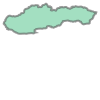

In [122]:
from shapely.geometry import MultiPolygon, Polygon

footprint = None
for i in nReserve['geometry']:
    footprint = i
    
footprint

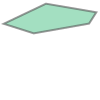

In [123]:
from shapely.geometry import MultiPolygon, Polygon

footprint = None
for i in nReserve['geometry'].simplify(0.5):
    footprint = i
    
footprint

In [124]:
products = api.query(footprint,
                     date = ('20190601', '20190626'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [22]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

NameError: name 'products' is not defined

In [ ]:
api.download("16e95baf-bbcb-43fe-ab67-5fecea2ffde5")

In [ ]:
# Open Bands 4, 3 and 2 with Rasterio
R10 = 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/GRANULE/L2A_T33TTG_A011731_20190605T100530/IMG_DATA/R10m'
b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b3 = rio.open(R10+'/T33TTG_20190605T100039_B03_10m.jp2')
b2 = rio.open(R10+'/T33TTG_20190605T100039_B02_10m.jp2')


# Create an RGB image 
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

In [ ]:
nReserve_proj = nReserve.to_crs({'init': 'epsg:32633'})

with rio.open("RGB.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)